# Artificial Neural networks

## The seasons of AI

The development of AI have always been met with hype cycles.
As seen with the McCulloch Pitts model, many foundations of "*AI*" have already been laid out in the 1940/1950s, but these constructs failed to meet their high expectations and promises, which finally lead to an abandonment of *AI* research, a circumstance labeled as an [AI Winter](https://en.wikipedia.org/wiki/AI_winter).

In the early 1980s, new architectures in neural networks and training methods re-initiated an interest in neural networks, but the the promised advancements were not met and by the 1990s other machine learning methods such as [Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine) were the focus of attention, which offered more reliable results in a more comprehensive theoretical framework, therefore the AI research went out of focus in the 90s.

The exact starting point of the current hype wave of AI or artifical neural networks is hard to pin down, but one crucial development were the results of [*AlexNet*](https://en.wikipedia.org/wiki/AlexNet) in 2012, which managed to get an increase in accuracy by 10% over the next entry, a rare circumstance which gets lots of attention. 
One thing that AlexNet taken advantage of was to use [*convolutions*](https://en.wikipedia.org/wiki/Kernel_(image_processing)) as a learnable part of a neural network architecture.
This architecture is inspired by the biological structure of the neurons within the visual cortex and was already proposed in the 1980s as [*Neocognitron*](https://en.wikipedia.org/wiki/Neocognitron).
But only due to the wide and cheap availability of GPUs through the gaming industry (which helped to reduce the time for the training procedure from months to days), as well as the availability of big datasets through the capturing measures of big data companies (which allowed to train a neural network with billions of parameters on a dataset of millions of pictures instead of thousands) allowed to re-visit the proposed architecture from the 1980s with big success.

The question of the current season of AI is therefore always apparent and unclear and is caused as well as a reason of the unpredictable nature of AIs topologies, which allows to enter the realm of dreams and desires of companies which try to construct new opportunities of profits, therefore the dreams of companies have to be realized by *"AI"*, and a failing of this does not result in a disadvantage for the dreamer but for the dream itself.

*AI* is therefore not a recent or new field of research, but had a coming and going which has been attached to the availability or lack of breakthroughs.

## How to program a neural network

While traditional programming uses algorithms to describe the output for a given input, programming neural networks involves more setting up an environment or topology with many degrees of freedom (*"variables"*) and a *traning* process, in which these degrees of freedom are tuned to a set of *samples* which traditionally contain a *sample* of the input data and an associated desired output.

There are lots of variations of how this topology or this training process can be constructed, and new paths in the structuring of these 

This setup still requires the use a combination of different crucial algorithms such as [AutoDiff](https://en.wikipedia.org/wiki/Automatic_differentiation) (an algorithm for automatic partial differentiation) or optimizing algorithms such as [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam).
Instead of implementing those algorithms oneself, it is possible to use libraries which implement a variety of these algorithms and also have optimized versions for GPU available and there is a variety of libraries available these days.

This course will use [*PyTorch Lightning*](https://lightning.ai/docs/pytorch/stable/) which implement common default and is build on top of [*PyTorch*](https://pytorch.org/), which provides a Python interface to all the necessary algorithms for the following chapters.

## Fully connected neural networks

A *fully connected neural network* is one of the basic architectures of neural networks.
It works by having multiple *layers* which each consist of multiple *neurons*.
Each neuron of a layer is connected to every neuron of its successive layer, therefore it is called a *fully connected* layer or neural network.
Each connection is modeled as a multiplication of the value with a *weight* of the connection.
All incoming connections of a neuron are then summed together, resulting in a new value which either acts as the output or act as intermediate value used as input for another layer (in which case the layer is called a hidden layer).

```{figure} https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg
:alt: An artifical neural network with 3 fully connected layers
:align: center

An artifical neural network with an input layer which consists of 3 input neurons, a hidden layer consisting of 4 neurons and an output layer with two neurons.
As all every neuron is *connected* with every neuron in the subsequent layer, this is called a *fully connected* network.
Note that the connections are also directed, so there is no way to introduce feedback loops - something which biological networks tend to form.
Source: <https://en.wikipedia.org/wiki/File:Colored_neural_network.svg>
```

## Implementation and iteration

### Simple FCNN

As a first introduction to neural networks, we will formulate, train, and evaluate a fully connected neural network that simply predicts the next note given the current note.
This is somehow similar to the previous discussed Perceptron and Markov chain discussed earlier.

Our goal is to predict the next note given a sequence of notes.

In [ ]:
import lightning as L
import numpy as np
import torch
import torch.nn as nn


class SimpleFCNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 1 input neuron -> hidden layer w/ 4 neurons
            # we add a bias neuron to account for offsets
            nn.Linear(1, 4, bias=True),
            # relu layer as activation
            nn.ReLU(),
            # hidden layer w/ 4 neurons -> 1 output neuron
            nn.Linear(4, 1, bias=True),
        )

    def forward(self, x):
        # scalar value needs to be wrapped into a an
        # additional dimension
        x = x.unsqueeze(1)

        # z is the predicted note
        z = self.net(x)

        return z

    def training_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self.forward(x)

        loss = nn.functional.mse_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        test_loss = nn.functional.mse_loss(y_hat, y.unsqueeze(1))
        self.log("test_loss", test_loss)
        return test_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


simple_fcnn = SimpleFCNN()

print(simple_fcnn)

SimpleFCNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)


In [ ]:
from pytorch_lightning.utilities.model_summary import ModelSummary

ModelSummary(model=simple_fcnn)

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 13     | train
--------------------------------------------
13        Trainable params
0         Non-trainable params
13        Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode

The summary above tells us that we have 13 parameters.

$$
\underbrace{((1+\underbrace{1}_{\text{bias}})*4)}_{\text{input -> hidden}} + \underbrace{((4+\underbrace{1}_{\text{bias}})*1)}_{\text{hidden -> output}} = 13
$$

There is also the question on how to evaluate the performance?
In the `training_step` method we refer to a *mse_loss* which stands for [*mean squared error*](https://en.wikipedia.org/wiki/Mean_squared_error), which is simply the average error squared (it is squared so a negative and positive error do not cancel out each other but do indeed accumulate), so

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( Y_i - \hat{Y_i}\ \right) ^2
$$

where $Y$ being the actual value and $\hat{Y}$ the predicted value.

Now it is time to actually load the data.

In [ ]:
import pandas as pd
from ki_ueben.datasets import Maestro3Dataset
from ki_ueben.midi import PianoRoll
from tqdm import tqdm

note_dfs = []
maestro_files = Maestro3Dataset()

# limit files - set to -1 for no limits
NUM_FILES = 100

# limit to first 100
for midi_path in tqdm(maestro_files[:NUM_FILES]["file_path"]):
    piano_roll = PianoRoll(midi_path)
    df_events = piano_roll.events()
    # filter out pedal (note=-1) and note_off events (velocity=0)
    df_events = df_events[(df_events["note"] > 0) & (df_events["velocity"] > 0)]
    df_events["note"]
    note_dfs.append(df_events)

simple_df = pd.concat(note_dfs)
simple_df

100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


,note,velocity,time
1,77,56,0.994792
2,49,32,0.998698
4,73,58,1.108073
6,68,58,1.207031
8,73,62,1.315104
...,...,...,...
4811,69,60,216.302083
4812,78,70,216.867188
4816,79,68,217.937500
4818,71,57,217.954427


As we want to predict the *next* note, we need to create a pair of the given sequence ($X$) and the target value ($y$).
This can by simply shifting the data indices by 1.

In [ ]:
from torch.utils.data.dataset import TensorDataset

# offset the data by 1 between X and y
simple_data_X = simple_df.iloc[:-1]["note"].to_numpy()
simple_data_y = simple_df.iloc[1:]["note"].to_numpy()

simple_dataset = TensorDataset(
    # convert midi note (int) to float as neural networks require floating
    # point numbers to calculate gradients, not discrete integers
    torch.from_numpy(simple_data_X).to(dtype=torch.float32),
    torch.from_numpy(simple_data_y).to(dtype=torch.float32),
)

In [ ]:
num_train_items = int(len(simple_dataset) * 0.8)
num_test_items = len(simple_dataset) - num_train_items

# split the dataset
simple_train, simple_test = torch.utils.data.random_split(
    dataset=simple_dataset,
    lengths=[num_train_items, num_test_items],
    # manual seeding so split is deterministic
    generator=torch.Generator().manual_seed(42),
)

To actually feed a stream of data into a neural network we use a [`DataLoader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).
This is necessary as we most likely can't fit all data at once through our neural network.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    simple_train, batch_size=128, num_workers=4, persistent_workers=True
)
test_loader = DataLoader(simple_test, batch_size=512)

Now we are set and we can start the actual training process.
We will limit our training to 5 *epochs* - we will 

In [ ]:
from pytorch_lightning.loggers import CSVLogger

simple_trainer = L.Trainer(
    max_epochs=5,
    logger=[
        # we store the metrics into a CSV file so we can take a look at its progress later
        CSVLogger(save_dir="logs", name="simple_fcnn", version=0)
    ],
)
simple_trainer.fit(model=simple_fcnn, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/simple_fcnn/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/simple_fcnn/version_0/checkpoints exists and is not empty.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 13     | train
--------------------------------------------
13        Trainable params
0         Non-trainable params
13        Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 0:   1%|          | 25/2864 [00:00<01:16, 37.03it/s, v_num=0, train_loss=8.28e+3]

/var/folders/v0/7q67mljd4v9_frk_1p_mr2ph0000gn/T/ipykernel_11183/2857180159.py:37: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(y_hat, y)


Epoch 1:   1%|          | 20/2864 [00:00<00:26, 106.37it/s, v_num=0, train_loss=385.0]   

/var/folders/v0/7q67mljd4v9_frk_1p_mr2ph0000gn/T/ipykernel_11183/2857180159.py:37: UserWarning: Using a target size (torch.Size([110])) that is different to the input size (torch.Size([110, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(y_hat, y)


Epoch 4: 100%|██████████| 2864/2864 [00:21<00:00, 134.30it/s, v_num=0, train_loss=258.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2864/2864 [00:21<00:00, 134.26it/s, v_num=0, train_loss=258.0]


The training of even such a very simple network takes some time, but hopefully we will see that the loss will lower over time.
To read the CSV data into Python we will use pandas again.

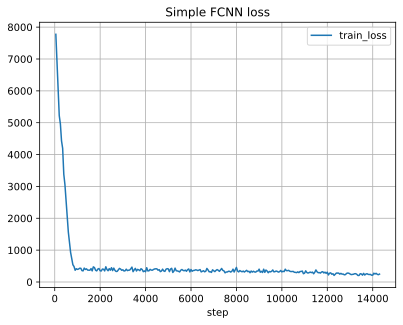

In [ ]:
import pandas as pd

%config InlineBackend.figure_format = 'svg'

df_simple_metrics = pd.read_csv("logs/simple_fcnn/version_0/metrics.csv")
df_simple_metrics.plot.line(
    grid=True,
    title="Simple FCNN loss",
    x="step",
    y="train_loss",
);

We can now evaluate the model on our test data.

In [ ]:
simple_trainer.test(model=simple_fcnn, dataloaders=test_loader);

/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 179/179 [00:01<00:00, 119.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            176.2259521484375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Like previously in our mark chain, we can now iterate over the net by guessing the next note.

In [ ]:
latest_note = 38

notes = []

for _ in range(10):
    notes.append(latest_note)
    latest_note = int(simple_fcnn.net(torch.Tensor([float(latest_note)]))[0])

print(notes)

[38, 54, 60, 62, 62, 62, 62, 62, 62, 62]


### Predicting probabilities

So training neural networks is not too hard, but the network is not too complex yet.

One problem at the moment, however, is that it will always output the same *road* for a given starting note, because the network has been trained to output a value based on an input.

To make our output more flexible, we want to output, similar to the Markov chain, a probability distribution for the next note, given the current note.

To get this work we will need to adapt the in- and output dimensions of the neural network as it now needs to predict the probability for each possible successive note.
We also need to transform our dataset as it needs now to be [one-hot vectors](https://en.wikipedia.org/wiki/One-hot).

In [ ]:
class ProbabilityFCNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 1 input neuron -> hidden layer w/ 4 neurons
            # we add a bias neuron to account for offsets
            nn.Linear(88, 24, bias=True),
            # relu layer as activation
            nn.ReLU(),
            # hidden layer w/ 4 neurons -> 1 output neuron
            nn.Linear(24, 88, bias=True),
        )
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        z = self.net(x)
        return z

    def training_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self.forward(x)

        loss = self.criterion(y_hat, torch.argmax(y, dim=1))
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


probability_fcnn = ProbabilityFCNN()

print(probability_fcnn)

ProbabilityFCNN(
  (net): Sequential(
    (0): Linear(in_features=88, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=88, bias=True)
  )
  (criterion): CrossEntropyLoss()
)


In [ ]:
ModelSummary(model=probability_fcnn)

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | net       | Sequential       | 4.3 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode

That is already a lot more parameters - sit down for one moment and try to understand why there are now so much more parameters by calculating the number of parameters manually.

We will continue by transforming our dataset.

In [ ]:
# -21 to scale data down to 0
one_hot_data = np.eye(88)[simple_df["note"].values - 21]

# offset the data by 1 between X and y
probability_data_X = one_hot_data[:-1]
probability_data_y = one_hot_data[1:]

probability_dataset = TensorDataset(
    # convert midi note (int) to float as neural networks require floating
    # point numbers to calculate gradients, not discrete integers
    torch.from_numpy(probability_data_X).to(dtype=torch.float32),
    torch.from_numpy(probability_data_y).to(dtype=torch.float32),
)

# one sample vector
one_hot_data[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [ ]:
probability_train_loader = DataLoader(
    probability_dataset, batch_size=128, num_workers=4, persistent_workers=True
)

probability_trainer = L.Trainer(
    max_epochs=5,
    logger=[
        # we store the metrics into a CSV file so we can take a look at its progress later
        CSVLogger(save_dir="logs", name="probability_fcnn", version=0)
    ],
)

probability_trainer.fit(
    model=probability_fcnn, train_dataloaders=probability_train_loader
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/probability_fcnn/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/probability_fcnn/version_0/checkpoints exists and is not empty.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | net       | Sequential       | 4.3 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated m

Epoch 4: 100%|██████████| 3580/3580 [00:30<00:00, 117.22it/s, v_num=0, train_loss=3.660]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 3580/3580 [00:30<00:00, 117.19it/s, v_num=0, train_loss=3.660]


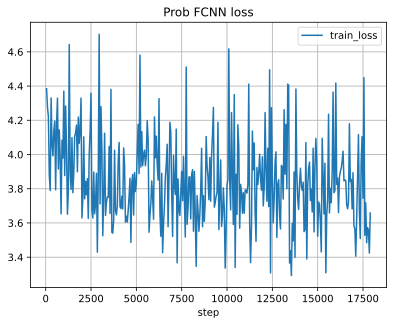

In [ ]:
df_prob_metrics = pd.read_csv("logs/probability_fcnn/version_0/metrics.csv")
df_prob_metrics.plot.line(
    grid=True,
    title="Prob FCNN loss",
    x="step",
    y="train_loss",
);

In [ ]:
START_NOTE = 60

start_vector = np.eye(88)[START_NOTE - 21]

logits_vector = probability_fcnn(torch.Tensor(start_vector))
prob_vector = torch.softmax(logits_vector, dim=0).detach().numpy()

prob_vector

array([5.3904032e-06, 9.7931224e-06, 6.5958493e-06, 1.1832035e-04,
       2.0422945e-05, 7.9910802e-05, 2.0841567e-04, 2.4010161e-04,
       2.8074645e-03, 3.2075937e-04, 8.9785451e-04, 1.3693562e-03,
       1.7685634e-03, 5.4534886e-04, 1.3101222e-03, 1.1381200e-02,
       1.0323367e-03, 3.5103934e-03, 3.4037919e-03, 4.4841897e-03,
       7.0898021e-03, 2.4060169e-03, 9.7995587e-03, 3.7993125e-03,
       8.2788365e-03, 6.7118732e-03, 4.8370576e-03, 6.3701861e-02,
       4.1270871e-03, 1.3559097e-02, 1.3995913e-02, 1.0293804e-02,
       2.6983807e-02, 7.9926075e-03, 4.3171227e-02, 1.5701288e-02,
       5.1756598e-02, 2.3058120e-02, 1.7784920e-02, 1.9332737e-02,
       7.0023746e-03, 3.7463475e-02, 6.4986460e-02, 3.7811551e-02,
       4.0689424e-02, 1.5034327e-02, 4.5700327e-02, 1.7222449e-02,
       3.2818682e-02, 1.6703313e-02, 1.2920220e-02, 6.1218675e-02,
       4.2455150e-03, 1.8142229e-02, 2.6042564e-02, 1.2941089e-02,
       1.8677060e-02, 4.6163960e-03, 2.7335418e-02, 9.3086008e

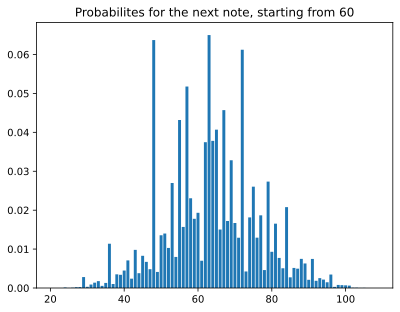

In [ ]:
import matplotlib.pyplot as plt

plt.title(f"Probabilites for the next note, starting from {START_NOTE}")
plt.bar(x=np.arange(0, 88) + 21, height=prob_vector);

We can now turn this into a series again.

In [ ]:
np.random.choice(np.arange(prob_vector.shape[0]), p=prob_vector)

29

In [ ]:
START_NOTE = 60

start_vector = np.eye(88)[START_NOTE - 21]
notes = [START_NOTE]

for _ in range(40):
    logits_vector = probability_fcnn(torch.Tensor(start_vector))
    prob_vector = torch.softmax(logits_vector, dim=0).detach().numpy()
    next_note = np.random.choice(np.arange(prob_vector.shape[0]), p=prob_vector)
    notes.append(next_note)
    start_vector = torch.tensor(
        np.eye(prob_vector.shape[0])[next_note], dtype=torch.float32
    )

", ".join([str(note) for note in notes])

'60, 39, 66, 63, 67, 44, 27, 39, 26, 34, 55, 46, 48, 50, 58, 58, 54, 49, 43, 24, 12, 19, 36, 46, 58, 39, 43, 56, 45, 48, 39, 44, 53, 51, 48, 49, 11, 9, 23, 40, 52'

We already are not stuck anymore on a single note!

### Adding context

Although the model already improved, we can still improve it by providing some context through a series of notes as input, e.g. the latest 5.

As we currently don't want to go into details about multi-dimensional input data with means such as convolution, we will simply concatenate the 5 vectors into one long vector as input and will output only 1 vector.
The network should figure out the importance of each input-dimension by itself.

In [ ]:
CONTEXT_NUM_NOTES = 5


class ContextFCNN(L.LightningModule):
    def __init__(self, num_notes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_notes * 88, 24, bias=True),
            nn.ReLU(),
            nn.Linear(24, 88, bias=True),
        )
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x: torch.Tensor):
        # turn 5x88 matrix into 440 dim vector
        x = x.flatten(1)
        z = self.net(x)
        return z

    def training_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self.forward(x)

        loss = self.criterion(y_hat, torch.argmax(y, dim=1))
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


context_fcnn = ContextFCNN(num_notes=CONTEXT_NUM_NOTES)

print(context_fcnn)

ContextFCNN(
  (net): Sequential(
    (0): Linear(in_features=440, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=88, bias=True)
  )
  (criterion): CrossEntropyLoss()
)


In [ ]:
ModelSummary(context_fcnn)

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | net       | Sequential       | 12.8 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
12.8 K    Trainable params
0         Non-trainable params
12.8 K    Total params
0.051     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode

Again, we also need to adjust our data transformation workflow.

In [ ]:
# -21 to scale data down to 0
one_hot_data = np.eye(88)[simple_df["note"].values - 21]

# offset the data by 1 between X and y
probability_data_X = one_hot_data[:-1]
probability_data_y = one_hot_data[1:]

probability_dataset = TensorDataset(
    # convert midi note (int) to float as neural networks require floating
    # point numbers to calculate gradients, not discrete integers
    torch.from_numpy(probability_data_X).to(dtype=torch.float32),
    torch.from_numpy(probability_data_y).to(dtype=torch.float32),
)

# one sample vector
one_hot_data[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [ ]:
context_X = []
context_y = []

# not efficient, but works
for i in range(one_hot_data.shape[0] - CONTEXT_NUM_NOTES):
    context_X.append(one_hot_data[i : i + CONTEXT_NUM_NOTES])
    context_y.append(one_hot_data[i + CONTEXT_NUM_NOTES])

context_X = np.array(context_X)
context_y = np.array(context_y)

print(f"context_X: {context_X.shape}, context_y: {context_y.shape}")

context_X: (458214, 5, 88), context_y: (458214, 88)


In [ ]:
context_dataset = TensorDataset(
    # convert midi note (int) to float as neural networks require floating
    # point numbers to calculate gradients, not discrete integers
    torch.from_numpy(context_X).to(dtype=torch.float32),
    torch.from_numpy(context_y).to(dtype=torch.float32),
)

In [ ]:
context_loader = DataLoader(
    dataset=context_dataset, batch_size=64, num_workers=4, persistent_workers=True
)

In [ ]:
context_trainer = L.Trainer(
    max_epochs=5,
    logger=[
        # we store the metrics into a CSV file so we can take a look at its progress later
        CSVLogger(save_dir="logs", name="context_fcnn", version=0)
    ],
)

context_trainer.fit(model=context_fcnn, train_dataloaders=context_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/context_fcnn/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/context_fcnn/version_0/checkpoints exists and is not empty.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | net       | Sequential       | 12.8 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
12.8 K    Trainable params
0         Non-trainable params
12.8 K    Total params
0.051     Total estimated model par

Epoch 4: 100%|██████████| 7160/7160 [01:03<00:00, 112.03it/s, v_num=0, train_loss=3.020]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 7160/7160 [01:03<00:00, 112.01it/s, v_num=0, train_loss=3.020]


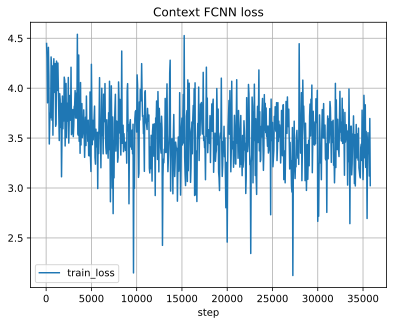

In [ ]:
df_prob_metrics = pd.read_csv("logs/context_fcnn/version_0/metrics.csv")
df_prob_metrics.plot.line(
    grid=True,
    title="Context FCNN loss",
    x="step",
    y="train_loss",
);

The training loss does not look very good - it is hard to say what the problem here is.
We can still use the method form before to continue a sequence.

In [ ]:
START_SEQUENCE = [60, 58, 60, 53, 55]

start_vector = np.eye(88)[START_SEQUENCE]
notes = [*START_SEQUENCE]

for i in range(40):
    logits_vector = context_fcnn.forward(
        torch.Tensor(start_vector).unsqueeze(0)
    ).squeeze(0)
    prob_vector = torch.softmax(logits_vector, dim=0).detach().numpy()
    next_note = np.random.choice(np.arange(prob_vector.shape[0]), p=prob_vector)
    notes.append(next_note)
    start_vector = torch.tensor(
        np.eye(88)[notes[(i + 1) : (i + 1) + 5]], dtype=torch.float32
    )

", ".join([str(note) for note in notes])

'60, 58, 60, 53, 55, 43, 57, 58, 53, 55, 58, 46, 58, 58, 52, 53, 56, 51, 46, 31, 53, 47, 43, 39, 46, 24, 34, 34, 45, 41, 50, 34, 33, 34, 43, 34, 31, 34, 27, 43, 29, 46, 29, 48, 46'

Although fully-connected artificial networks already gave us some insights into machine learning we will stop here.
One problem that we are facing currently is that the size of our context needs to be of fixed size - this means our network will grow more and more if we want more context, which is problematic because it takes longer to train and also takes more data to train a bigger network.

Instead we will take a look into *recurrent neural networks* (RNN), which implement a feedback loop which we can use to create a context of arbitrary size.

```{admonition} Task
* Try to add time and/or velocity into the neural network by extending its in- and output structure
* Instead of the MSE (mean squared error), we now use a *cross entropy loss* - why?
* What is the softmax function and why do we apply it on the output of our network?
* Use OSC to create a communication bridge between SuperCollider and Python - try to control a melody in SuperCollider via the neural network. Take a look at [`python-osc`](https://github.com/attwad/python-osc)
```